# Добавляем библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Генирируем синтетические данные

Создаем функции для генерации синтетических данных

In [323]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise):
    return np.random.randn(*shape) *noise

def dataset(a, b, f = None,  N = 350, x_max =1, noise = 0, random_x = True,  seed = 90):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise)

    return y, y_true, np.atleast_2d(x).T

In [325]:
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Шумовые данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()


Создаем синтетический датасет и шумовые данные

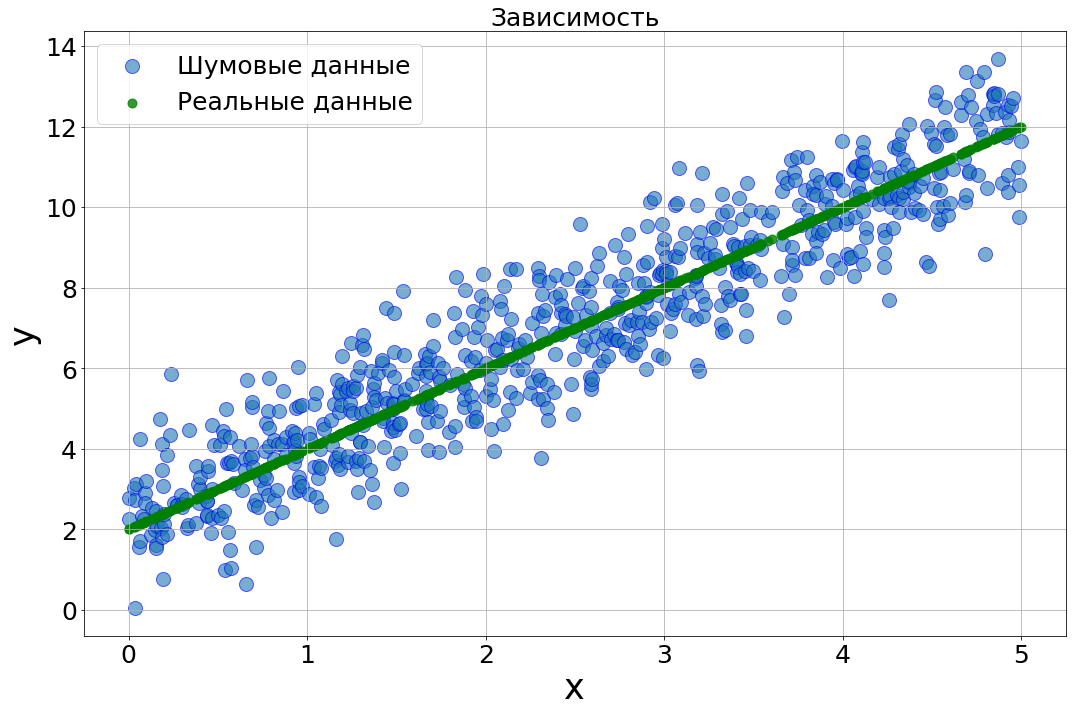

In [326]:
my_noise = 1

y, y_true, x = dataset(a = 2, b = 2,
                       f = None,  N = 700,
                       x_max = 5, 
                       noise = my_noise,
                       seed =90)
vis_data(y, y_true,x, 'Зависимость')

Разделяем все данные для получения тренировочной и тестовой выборок

In [327]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=50, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


x_train, y_train, x_val, y_val, x_test, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, )    
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape,  x_test.shape, y_test.shape )

    
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(350, 1) (350,) (140, 1) (140,) (210, 1) (210,)
(489, 1) (489,) (211, 1) (211,)


In [328]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(489, 1) (489,) (211, 1) (211,)


Создаем класс для регрессии

In [329]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 500, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 90):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпохи', fontsize = 24)
        plt.ylabel('Функция потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

Делаем линейную регрессию

In [330]:
myreg = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
myreg.fit(x_train, y_train)

Смотрим на функцию потерь

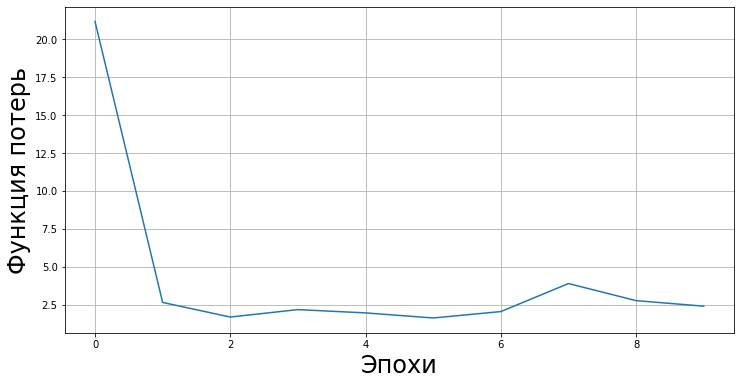

In [331]:
myreg.plot_cost()

In [332]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Тестовые данные", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

Смотрим график

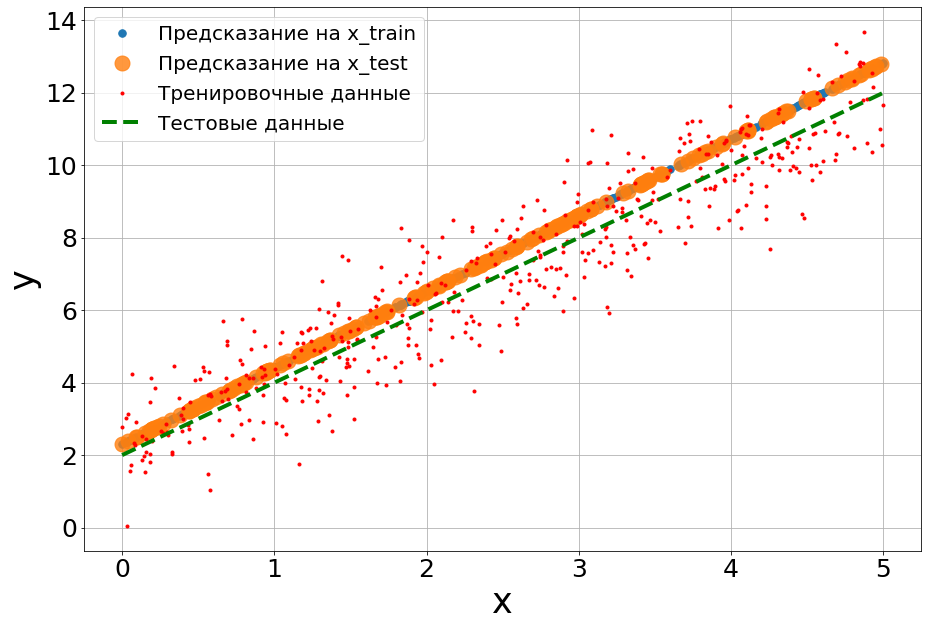

In [333]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, myreg)

**Вывод**

Чем больше шума, тем меньше значения потерь

# Полиномиальная зависимость

Делаем изменения в данных, добавим шумов, а также уменьшим максимальное значение x_max

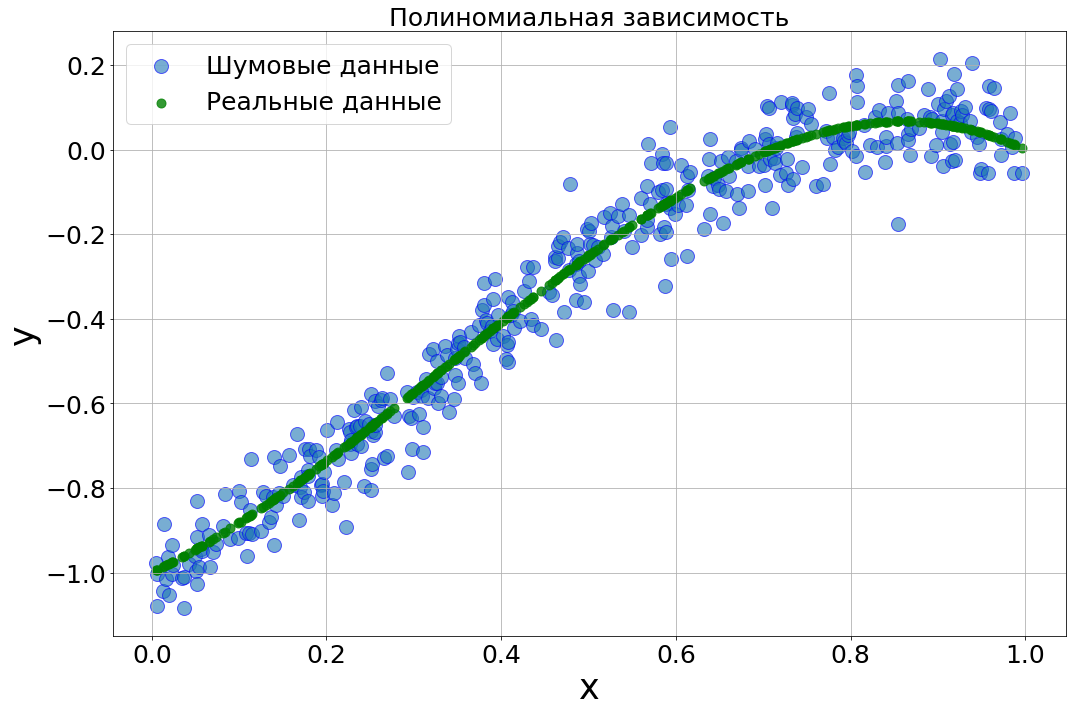

In [334]:
noise = 0.07

y, y_true, x = dataset(a = [1,2,-2], b = -1,
                       f = None,  N = 400,
                       x_max =1, 
                       noise = noise,
                       seed = 50)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

Создадим полином с 4 степенью

In [335]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T
  

In [336]:
x_ = to_polynom(x, order = 4) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3, )

Линейная регрессия

In [337]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

In [338]:
regr_poly.fit(x_train, y_train)

Взглянем на график

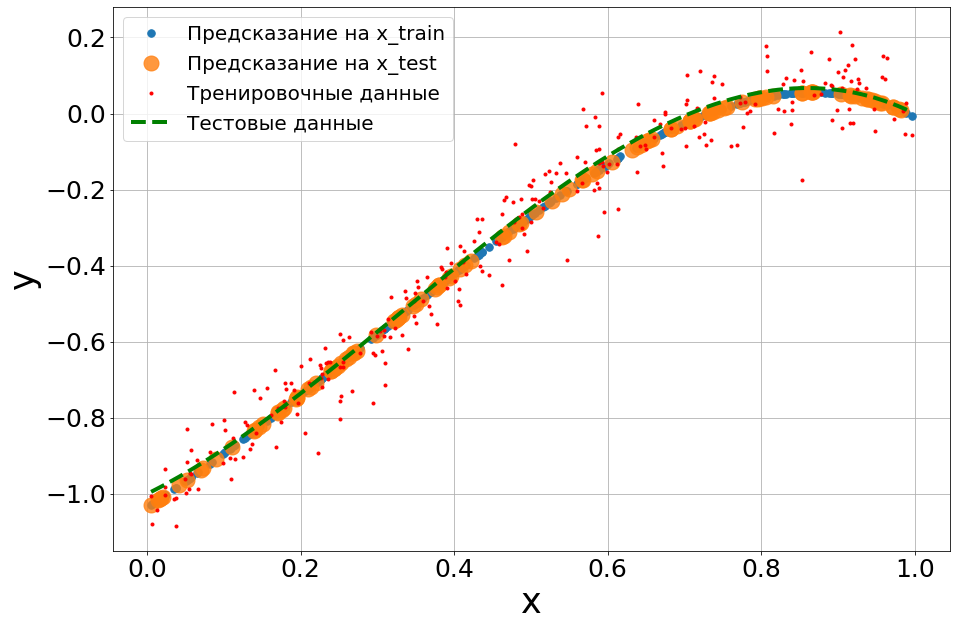

In [339]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)


Увеличим выборку, а затем посмотрим, на что это повлияет

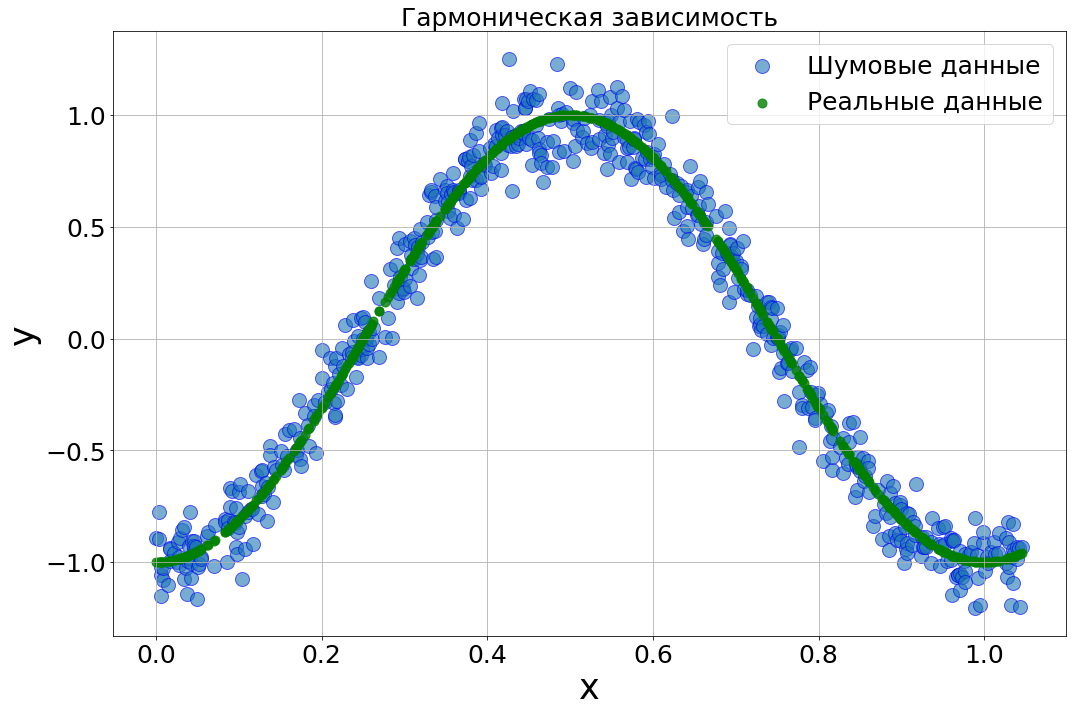

In [341]:
y, y_true, x = dataset(a = 2*np.pi,
                       b = np.pi, f = np.cos,  
                       N = 600, x_max =np.pi/3, 
                       noise = 0.1, seed = 123)
vis_data(y, y_true,x, 'Гармоническая зависимость')

In [342]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(420, 1) (420,) (180, 1) (180,)


Train Score = -0.03


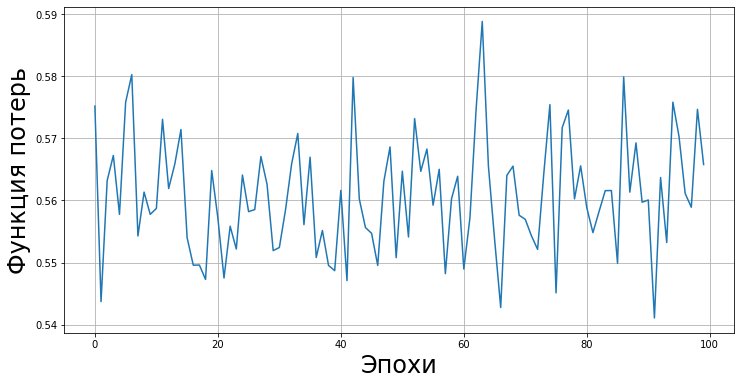

In [343]:
regr_harm = LinearRegression(learning_rate=0.25,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_harm.fit(x_train, y_train)

print(f'Train Score = {regr_harm.score(x_train, y_train):.2f}')
regr_harm.plot_cost()

In [344]:
w, b = regr_harm.get_w_and_b()
print(w,b)

[-0.31465698] 0.31747119391104484


Создим полином с 9 степенью

In [347]:
order  = 9

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8
416,0.279503,0.078122,0.021835,0.006103,1.705820e-03,4.767821e-04,1.332621e-04,3.724717e-05,1.041070e-05
417,0.591217,0.349537,0.206652,0.122176,7.223262e-02,4.270513e-02,2.524799e-02,1.492703e-02,8.825110e-03
418,0.035556,0.001264,0.000045,0.000002,5.682959e-08,2.020642e-09,7.184629e-11,2.554579e-12,9.083102e-14
419,0.843410,0.711340,0.599951,0.506004,4.267691e-01,3.599412e-01,3.035779e-01,2.560405e-01,2.159471e-01


Линейная регрессия

Test Score = 0.95, Train Score = 0.95


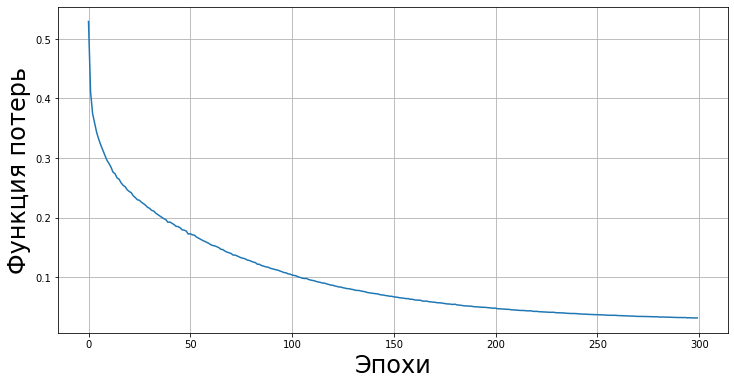

In [348]:
regr_harm_poly = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly.fit(x_train_, y_train)
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()

In [349]:
w, b = regr_harm_poly.get_w_and_b()
print(w,b)

[ 5.2115171  -0.41784459 -2.7643443  -2.9764511  -1.56758035 -1.37302962
  0.41132173  0.75580615  2.74639952] -1.118182706510351


Скейлеры

In [350]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [351]:
class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [352]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

In [353]:
pd.DataFrame(x_test_scaled).tail(4)

,0,1,2,3,4,5,6,7,8
176,-0.928774,-0.935526,-0.832160,-0.732315,-0.654032,-0.594298,-0.547832,-0.510596,-0.479894
177,-0.111007,-0.377818,-0.510975,-0.560299,-0.565256,-0.549427,-0.525438,-0.499514,-0.474443
178,-1.042913,-0.984237,-0.849135,-0.737654,-0.655609,-0.594744,-0.547954,-0.510628,-0.479903
179,1.046851,1.038318,0.932507,0.792976,0.646700,0.506632,0.378890,0.265927,0.168180


Линейная регрессия

Test Score = 0.96, Train Score = 0.96


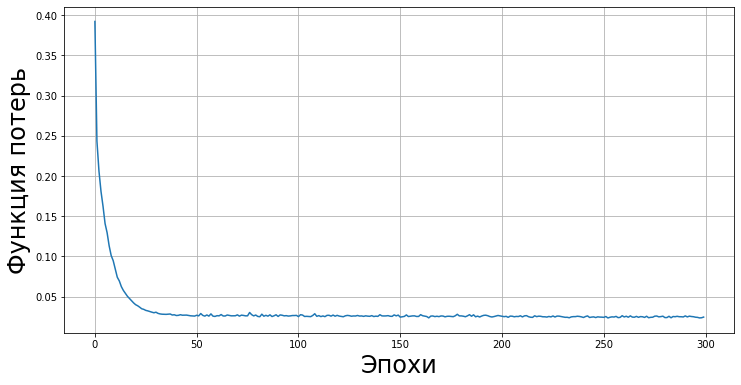

In [354]:
regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

Получаем веса

In [355]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.83538952 -0.18246671 -1.27569265 -1.26306385 -0.12235908 -0.49211029
  0.52500175 -0.04139937  0.93894704] -0.003300103898554014


In [356]:
np.sum(np.abs(w))

6.676430248326733

График

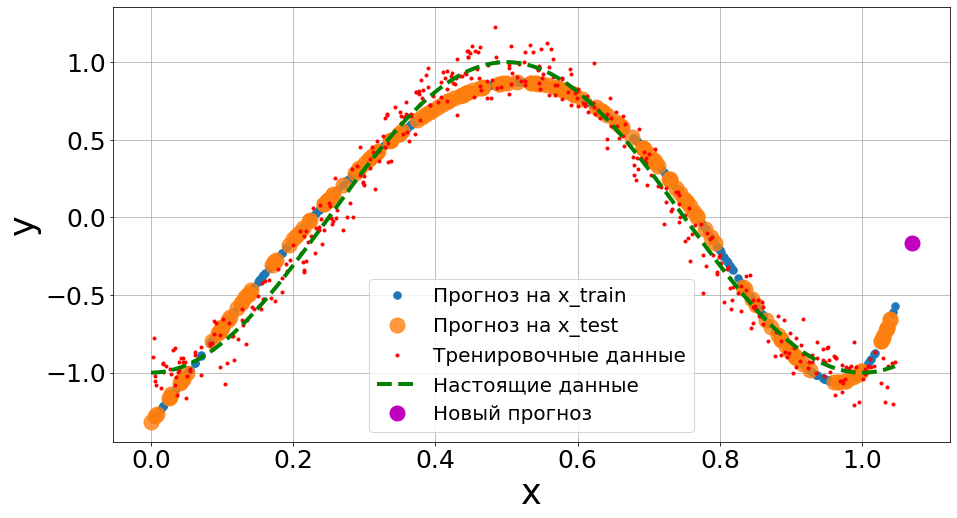

In [357]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Прогноз на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Прогноз на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Настоящие данные", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'Новый прогноз',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);



**Вывод**

Значительные неточности остались, хоть общая тенденция и отображена

Увеличим разрядность полинома до 20, и посмотрим что будет

In [358]:
order  = 20

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
416,0.279503,0.078122,0.021835,0.006103,1.705820e-03,4.767821e-04,1.332621e-04,3.724717e-05,1.041070e-05,2.909823e-06,8.133045e-07,2.273211e-07,6.353697e-08,1.775878e-08,4.963635e-09,1.387351e-09,3.877690e-10,1.083826e-10,3.029329e-11,8.467068e-12
417,0.591217,0.349537,0.206652,0.122176,7.223262e-02,4.270513e-02,2.524799e-02,1.492703e-02,8.825110e-03,5.217552e-03,3.084704e-03,1.823728e-03,1.078219e-03,6.374608e-04,3.768775e-04,2.228162e-04,1.317327e-04,7.788256e-05,4.604547e-05,2.722285e-05
418,0.035556,0.001264,0.000045,0.000002,5.682959e-08,2.020642e-09,7.184629e-11,2.554579e-12,9.083102e-14,3.229603e-15,1.148323e-16,4.082995e-18,1.451757e-19,5.161890e-21,1.835370e-22,6.525872e-24,2.320350e-25,8.250274e-27,2.933481e-28,1.043033e-29
419,0.843410,0.711340,0.599951,0.506004,4.267691e-01,3.599412e-01,3.035779e-01,2.560405e-01,2.159471e-01,1.821319e-01,1.536118e-01,1.295577e-01,1.092702e-01,9.215953e-02,7.772824e-02,6.555676e-02,5.529120e-02,4.663314e-02,3.933084e-02,3.317201e-02


In [359]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

Test Score = 0.96, Train Score = 0.96


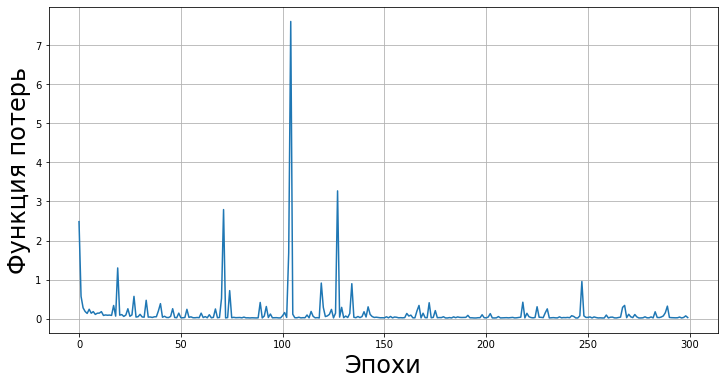

In [360]:
regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

Выводим веса

In [361]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.76868895e+00  1.15956123e-03 -1.12591611e+00 -1.27364151e+00
 -5.11389065e-01 -6.76352752e-01  1.41173625e-01 -6.67354649e-02
  7.92511290e-01  7.17572257e-01  1.30976717e-01  2.15719371e-01
  3.49207364e-01 -1.11697769e-01  8.19342155e-02  2.54402244e-01
  8.80552010e-02 -8.93286600e-02 -6.48817048e-01 -1.12155491e-01] 0.006253652203791565


In [362]:
np.sum(np.abs(w))

9.157434664579203

Отобразим график

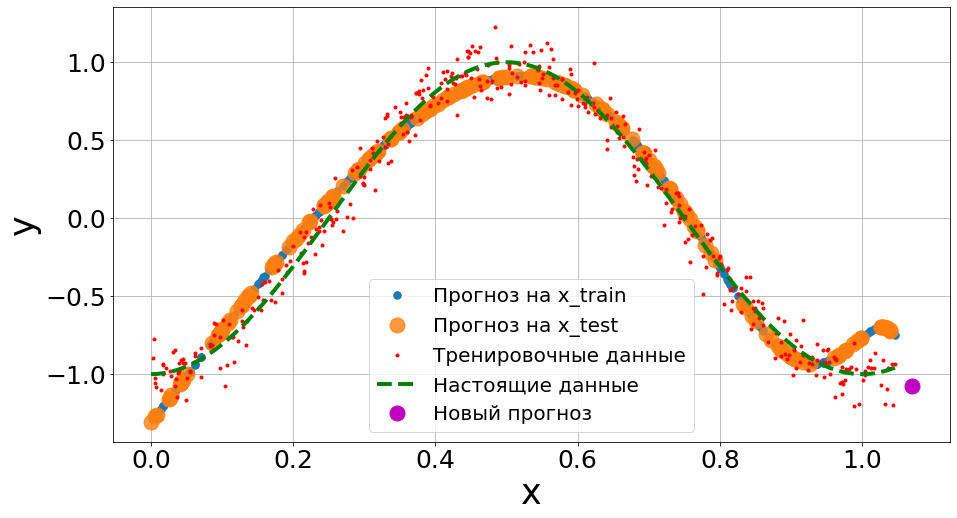

In [363]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Прогноз на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Прогноз на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Настоящие данные", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'Новый прогноз',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);



# Реальные данные (Cars Moldova)

Импорт библиотек и данных

In [370]:
from google.colab import files
import seaborn as sns; 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [369]:
uploaded = files.upload()

Saving cars_moldova_norm (1).csv to cars_moldova_norm (1).csv


In [371]:
df = pd.read_csv('/content/cars_moldova_norm.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,mileage
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727,medium
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000,medium
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000,medium
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000,medium
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667,medium
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000,medium
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714,medium
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000,medium


In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  32220 non-null  object 
 1   Model                 32220 non-null  object 
 2   Year                  32220 non-null  int64  
 3   Style                 32220 non-null  object 
 4   Distance              32220 non-null  float64
 5   Engine_capacity(cm3)  32220 non-null  float64
 6   Fuel_type             32220 non-null  object 
 7   Transmission          32220 non-null  object 
 8   Price(euro)           32220 non-null  float64
 9   Age                   32220 non-null  int64  
 10  km_year               32220 non-null  float64
 11  mileage               32220 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 2.9+ MB


In [373]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'mileage']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

Используем числовые столбцы для линейной регрессии

Разобъем данные на тренировочные и тестовые

In [374]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=140)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
 4   km_year               32220 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


,0,1,2,3
22549,0.54,0.299930,0.479167,0.248497
22550,0.60,0.122912,0.166667,0.115374
22551,0.90,0.049905,0.364583,0.164997
22552,0.72,0.223922,0.250000,0.297261
22553,0.92,0.140914,0.373958,0.563126


Класс для линейной регрессии

In [375]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15, mfc='none' ); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks(FontSize = 25)

    plt.yticks(FontSize = 25);

In [376]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 200, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 140):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

Запускаем линейную регрессию на основе данных

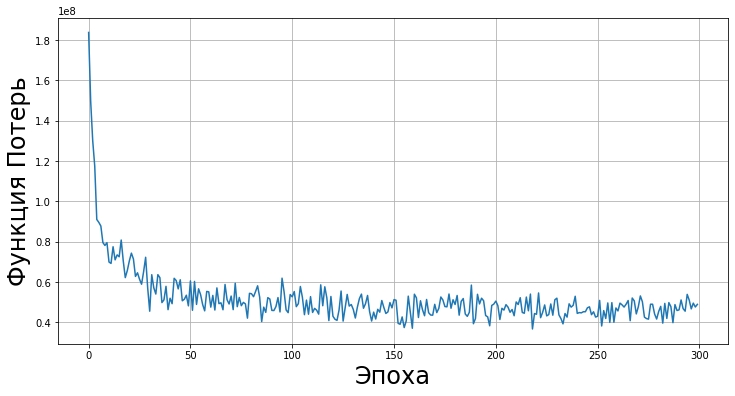

train R2: 0.4854; test R2: 0.4768


In [377]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Отображаем и смотрим веса

In [378]:
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels, rotation = 45 );

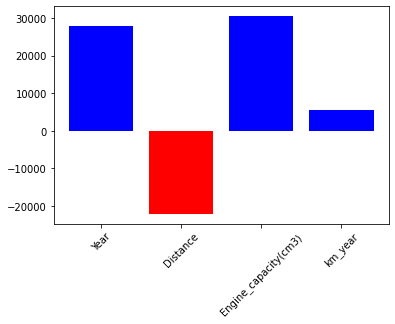

In [379]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [380]:
np.sum(np.abs(w))

85836.76061093569

Регуляризируем

In [381]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 200, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 140):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state)
        self.l2_penalty = l2_penalty
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term
                  
    
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term) 


Запускаем регрессию на основе регуляризации

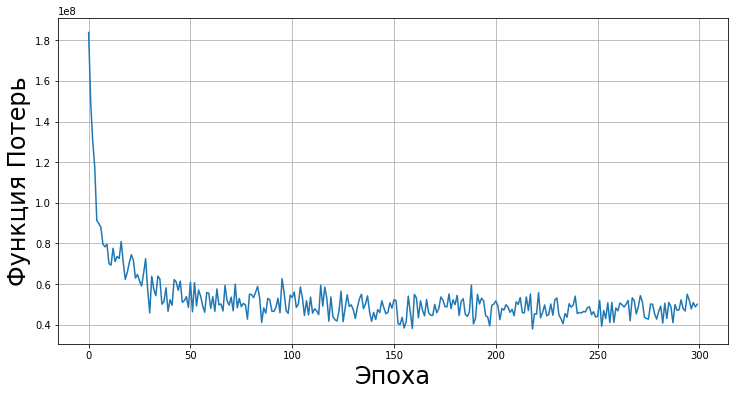

train R2: 0.4850; test R2: 0.4766


In [382]:
regr = RidgeRegression(learning_rate=0.5,epochs=300,batch_size=3000, l2_penalty = 0.001)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Выводим веса

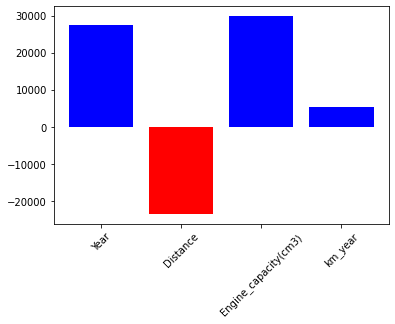

In [383]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [384]:
np.sum(np.abs(w))

86120.69034742688

Особо ничего не изменилось

# Различные типы предварительной обработки

Пробуем нормализовать датасет

In [385]:
DF_norm  = df_num.copy()
Xmin = df_num[num_columns].min()
Xmax = df_num[num_columns].max()

DF_norm[num_columns] = (df_num[num_columns]- Xmin)/( Xmax - Xmin)
DF_norm.head()

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
0,0.80,0.194919,0.333333,0.075651,0.353252
1,0.86,0.134913,0.270833,0.083667,0.336172
2,0.82,0.109911,0.270833,0.063627,0.218437
3,0.70,0.199920,0.291667,0.039078,0.248497
4,0.58,0.299930,0.416667,0.032966,0.271270


Разбиваем на тренировочную и тестовую выборки


In [386]:
X,y = DF_norm.drop(columns = ['Price(euro)']).values,DF_norm['Price(euro)'].values

features_names = DF_norm.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

,0,1,2,3
22549,0.40,0.011012,0.291667,0.005179
22550,0.74,0.208921,0.270833,0.297166
22551,0.84,0.155127,0.270833,0.343601
22552,0.84,0.219922,0.229167,0.487865
22553,0.94,0.049905,0.375000,0.248497


Производим рекгрессию

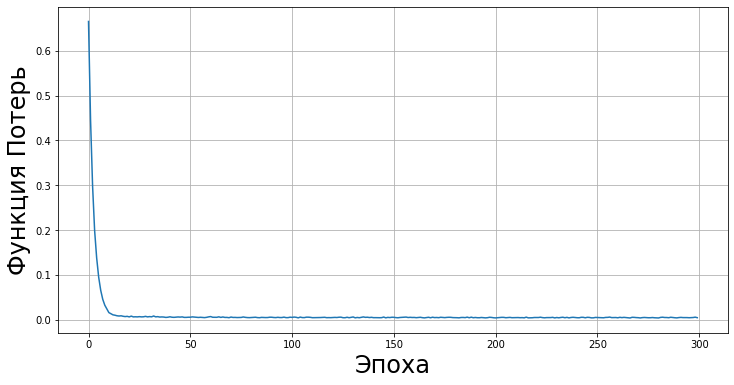

train R2: 0.4811; test R2: 0.4691


In [387]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Отображаем веса

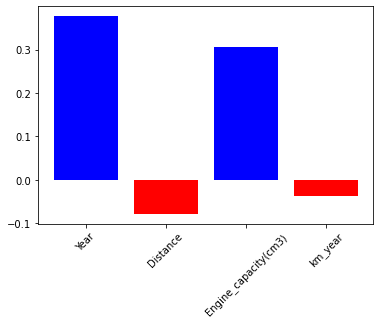

In [388]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [244]:
np.sum(np.abs(w))

0.7980972112517167

Благодаря нормализации мы смогли значительно улучшить результаты. График уменьшения потерь стал плавным, а веса и потери уменьшились

Стандатизируем данные

In [245]:
DF_scaled = df_num.copy()
M = df_num[num_columns].mean()
STD = df_num[num_columns].std()
DF_scaled[num_columns] = (df_num[num_columns]-M)/STD

DF_scaled.head()

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
0,0.376492,0.128983,-0.112516,-0.179081,0.377953
1,0.793761,-0.490816,-0.604496,-0.095044,0.261792
2,0.515582,-0.749065,-0.604496,-0.305136,-0.538943
3,-0.318957,0.180633,-0.440503,-0.562500,-0.334500
4,-1.153495,1.213632,0.543457,-0.626578,-0.179619


Тренировочная и тестовая выборки

In [246]:
X,y = DF_scaled.drop(columns = ['Price(euro)']).values,DF_scaled['Price(euro)'].values

features_names = DF_scaled.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

,0,1,2,3
22549,0.40,0.011012,0.291667,0.005179
22550,0.74,0.208921,0.270833,0.297166
22551,0.84,0.155127,0.270833,0.343601
22552,0.84,0.219922,0.229167,0.487865
22553,0.94,0.049905,0.375000,0.248497


Регрессия

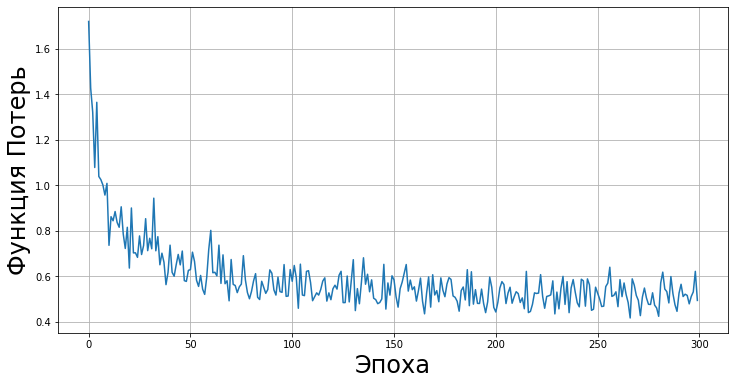

train R2: 0.4880; test R2: 0.4782


In [247]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Отображаем веса

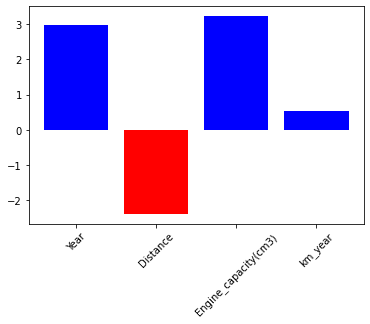

In [248]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [249]:
np.sum(np.abs(w))

9.123932411646747

Не смотря на ломанный график функции потерь, нам удалось уменьшить веса

# Добавляем категориальные признаки

One-hot кодирование

In [250]:
df_dum = df.copy()
df_dum = pd.get_dummies(df_dum[cat_columns])
df_dum

,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,Make_Citroen,Make_Dacia,Make_Daewoo,Make_Daihatsu,Make_Dodge,...,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Transmission_Automatic,Transmission_Manual,mileage_big,mileage_medium,mileage_small
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
32216,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
32217,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
32218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Добавляем нормализованные числовые признаки

In [251]:
df_dum['Year'] = DF_norm['Year']
df_dum['Distance'] = DF_norm['Distance']
df_dum['Engine_capacity(cm3)'] = DF_norm['Engine_capacity(cm3)']
df_dum['Price(euro)'] = DF_norm['Price(euro)']
df_dum['km_year'] = DF_norm['km_year']
df_dum

,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,Make_Citroen,Make_Dacia,Make_Daewoo,Make_Daihatsu,Make_Dodge,...,Transmission_Automatic,Transmission_Manual,mileage_big,mileage_medium,mileage_small,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0.80,0.194919,0.333333,0.075651,0.353252
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.86,0.134913,0.270833,0.083667,0.336172
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.82,0.109911,0.270833,0.063627,0.218437
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.70,0.199920,0.291667,0.039078,0.248497
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.58,0.299930,0.416667,0.032966,0.271270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32215,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0.90,0.087909,0.333333,0.113226,0.291917
32216,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.62,0.224922,0.333333,0.042084,0.223447
32217,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0.88,0.088909,0.270833,0.068136,0.252791
32218,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.70,0.369937,0.375000,0.038076,0.461423


In [252]:
X,y = df_dum.drop(columns = ['Price(euro)']).values,df_dum['Price(euro)'].values

features_names = df_dum.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
22549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.40,0.011012,0.291667,0.005179
22550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.74,0.208921,0.270833,0.297166
22551,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.84,0.155127,0.270833,0.343601
22552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.84,0.219922,0.229167,0.487865
22553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.94,0.049905,0.375000,0.248497


Для достижения более качественных результатов попробуем уменьщить скорость обучения и количество эпох

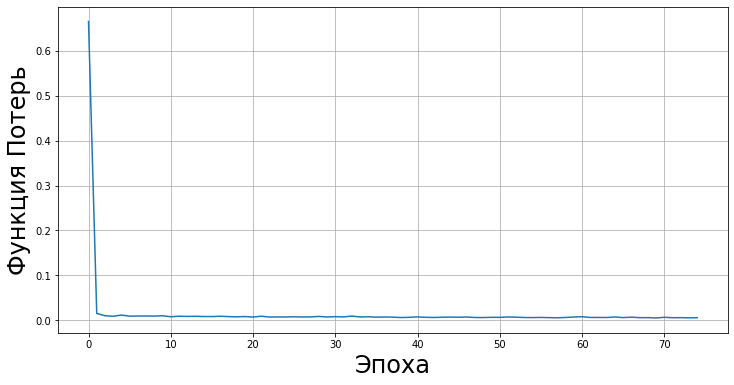

train R2: 0.3678; test R2: 0.3622


In [390]:
regr = LinearRegression(learning_rate=0.3,epochs=75,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

По графику можно увидеть, что точность предсказаний улучшилась, чего мы и добивались

# Анализируем веса

Показатели функции потерь говорят нам, что данный график самый точный

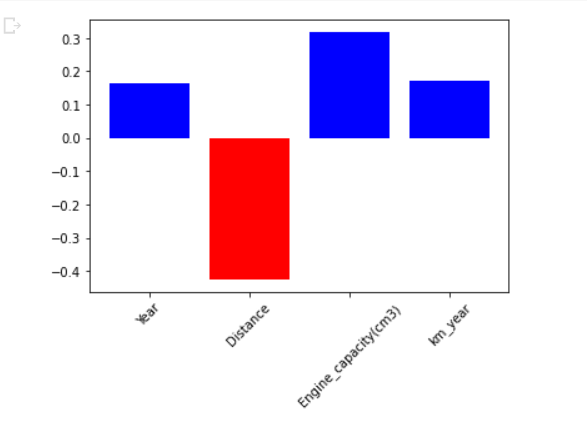

А значит колонки year и km_year имеют примерно равное значение в стоимости авто, Engine_capacity(cm3) - наивысшее, а Distance - отрицательное

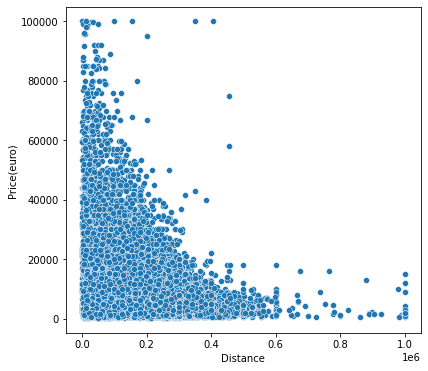

In [254]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='Distance',y='Price(euro)',data=df,ax=ax)